# 2.2 Key statistics

In [1]:
%load_ext autoreload
%autoreload 2

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
import zipfile
from pathlib import Path
import os
import sys
from IPython.display import display

# specfic soccer analysis packages
from mplsoccer import Pitch, Sbopen, VerticalPitch

# load custom functions
from src.visualization import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Individual games

In [54]:
match_id = "5414203"
df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)

In [55]:
team2 = 'Northern Ireland'
team1 = 'Slovenia'
title='EM Qualifier: 2023-09-07'
subtitle='2:4'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


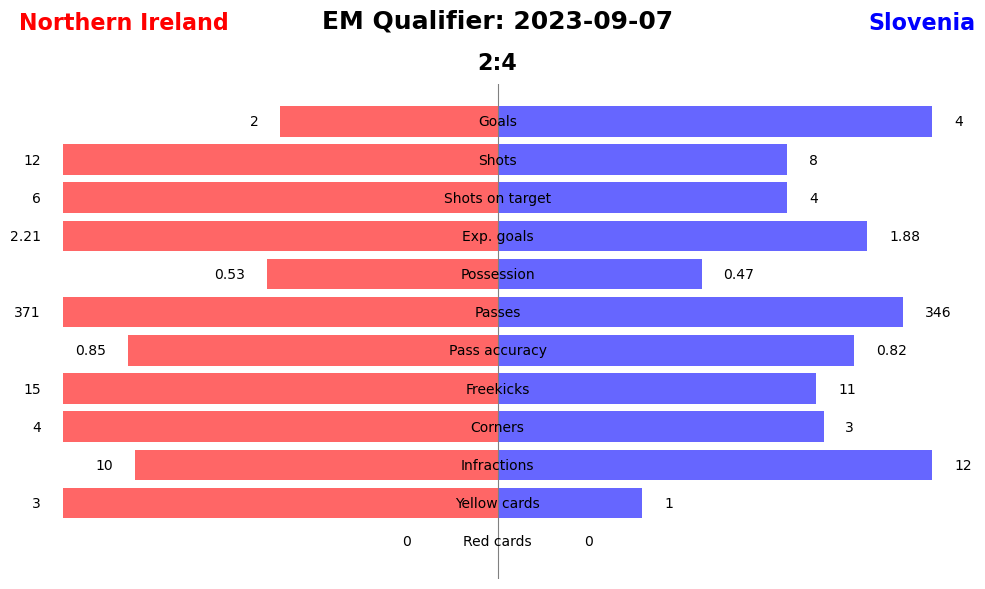

In [58]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)
shots_team2 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team2)]
shots_team1 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team1)]
passes_completed = df_events[df_events["type.primary"] == "pass"].groupby(['team.name'])['pass.accurate'].sum()
possession = df_events.groupby("team.name")["possession.duration"].sum() / df_events["possession.duration"].sum()

team2_data = {'Goals': 0 if shots_team2['shot.isGoal'].sum() == False else shots_team2['shot.isGoal'].sum(),
            'Shots': shots_team2.shape[0],
            'Shots on target':0 if shots_team2['shot.onTarget'].sum() == False else shots_team2['shot.onTarget'].sum(),
            'Exp. goals': shots_team2['shot.xg'].sum().round(2),
            'Possession': (possession.loc[team2]).round(2), # in percent
            'Passes': team_type_counts.loc[team2, 'pass'],
            'Pass accuracy': (passes_completed.loc[team2] / team_type_counts.loc[team2, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team2, 'free_kick'],
            'Corners': team_type_counts.loc[team2, 'corner'],
            'Infractions': team_type_counts.loc[team2, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0],
            }

team1_data = {'Goals': shots_team1['shot.isGoal'].sum(),
            'Shots': shots_team1.shape[0],
            'Shots on target': shots_team1['shot.onTarget'].sum(),
            'Exp. goals': shots_team1['shot.xg'].sum().round(2),
            'Possession': (possession.loc[team1]).round(2), # in percent
            'Passes': team_type_counts.loc[team1, 'pass'],
            'Pass accuracy': (passes_completed.loc[team1] / team_type_counts.loc[team1, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team1, 'free_kick'],
            'Corners': team_type_counts.loc[team1, 'corner'],
            'Infractions': team_type_counts.loc[team1, 'infraction'],
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0],
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0],
            }

# if category % do not normalize
perc_categories = ['Possession', 'Pass accuracy']

# plot statistics
plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title, 
                    subtitle=subtitle, team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/2-statistics/key_statistics_{match_id}.png')




## Denmark vs Slovenia aggregate

In [73]:
match_ids = ['5414302', '5414180']

team2 = 'Denmark'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'DEN vs SVN aggregate'

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


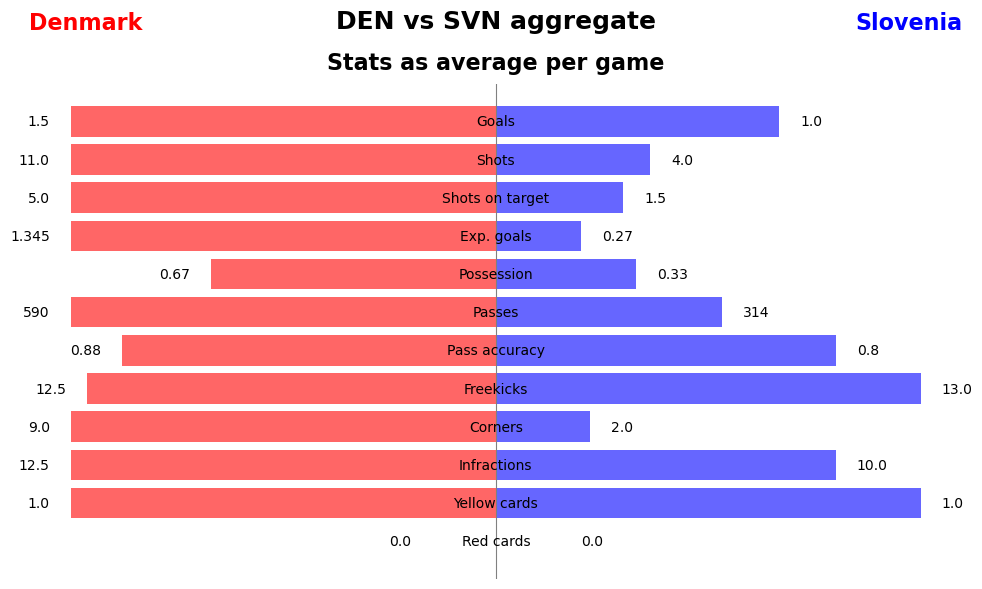

In [75]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)
shots_team2 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team2)]
shots_team1 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team1)]
passes_completed = df_events[df_events["type.primary"] == "pass"].groupby(['team.name'])['pass.accurate'].sum()
possession = df_events.groupby("team.name")["possession.duration"].sum() / df_events["possession.duration"].sum()
num_matches = len(match_ids)

team2_data = {'Goals': 0 if shots_team2['shot.isGoal'].sum() == False else shots_team2['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team2.shape[0] / num_matches,
            'Shots on target':0 if shots_team2['shot.onTarget'].sum() == False else shots_team2['shot.onTarget'].sum( ) / num_matches,
            'Exp. goals': shots_team2['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team2]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team2, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team2] / team_type_counts.loc[team2, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team2, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team2, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team2, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

team1_data = {'Goals': shots_team1['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team1.shape[0] / num_matches,
            'Shots on target': shots_team1['shot.onTarget'].sum() / num_matches,
            'Exp. goals': shots_team1['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team1]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team1, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team1] / team_type_counts.loc[team1, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team1, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team1, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team1, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

# if category % do not normalize
perc_categories = ['Possession', 'Pass accuracy']
# plot statistics
plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title, 
                    subtitle=subtitle, team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/2-statistics/key_statistics_DEN_SVN.png')


## All games aggregate

In [76]:
match_ids = ['5414324', '5414302', '5414284', '5414260', '5414226', '5414180', '5414103', '5414128', '5414156', '5414203']
opponent_names = ['Denmark', 'San Marino', 'Northern Ireland', 'Finland', 'Kazakhstan']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN EM Qualifiers aggregate'

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


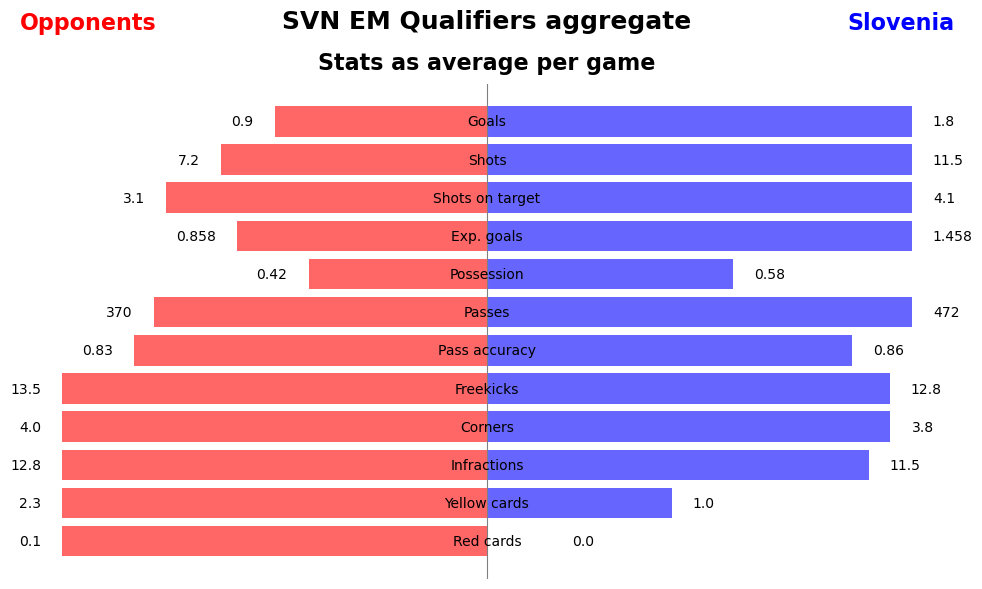

In [77]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)
shots_team2 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team2)]
shots_team1 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team1)]
passes_completed = df_events[df_events["type.primary"] == "pass"].groupby(['team.name'])['pass.accurate'].sum()
possession = df_events.groupby("team.name")["possession.duration"].sum() / df_events["possession.duration"].sum()
num_matches = len(match_ids)

team2_data = {'Goals': 0 if shots_team2['shot.isGoal'].sum() == False else shots_team2['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team2.shape[0] / num_matches,
            'Shots on target':0 if shots_team2['shot.onTarget'].sum() == False else shots_team2['shot.onTarget'].sum( ) / num_matches,
            'Exp. goals': shots_team2['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team2]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team2, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team2] / team_type_counts.loc[team2, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team2, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team2, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team2, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

team1_data = {'Goals': shots_team1['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team1.shape[0] / num_matches,
            'Shots on target': shots_team1['shot.onTarget'].sum() / num_matches,
            'Exp. goals': shots_team1['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team1]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team1, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team1] / team_type_counts.loc[team1, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team1, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team1, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team1, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

# if category % do not normalize
perc_categories = ['Possession', 'Pass accuracy']

# plot statistics
plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title, 
                    subtitle=subtitle, team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/2-statistics/key_statistics_SVN_agg.png')


## SVN vs weaker teams aggregate

In [78]:
match_ids = ['5414324', '5414226', '5414103', '5414128']
opponent_names = ['San Marino', 'Kazakhstan']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN vs weaker teams aggregate'

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


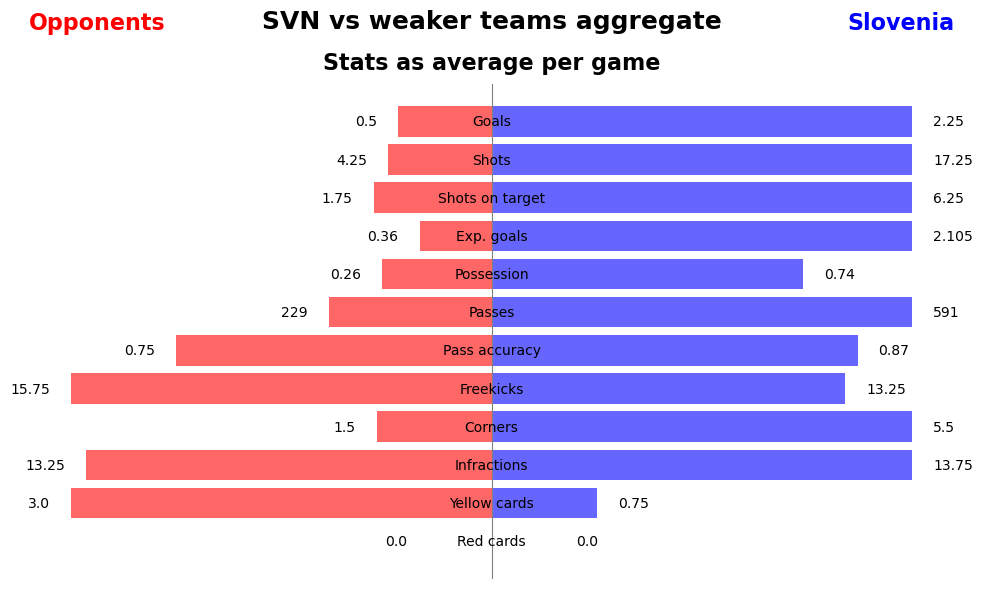

In [79]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)
shots_team2 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team2)]
shots_team1 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team1)]
passes_completed = df_events[df_events["type.primary"] == "pass"].groupby(['team.name'])['pass.accurate'].sum()
possession = df_events.groupby("team.name")["possession.duration"].sum() / df_events["possession.duration"].sum()
num_matches = len(match_ids)

team2_data = {'Goals': 0 if shots_team2['shot.isGoal'].sum() == False else shots_team2['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team2.shape[0] / num_matches,
            'Shots on target':0 if shots_team2['shot.onTarget'].sum() == False else shots_team2['shot.onTarget'].sum( ) / num_matches,
            'Exp. goals': shots_team2['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team2]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team2, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team2] / team_type_counts.loc[team2, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team2, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team2, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team2, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

team1_data = {'Goals': shots_team1['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team1.shape[0] / num_matches,
            'Shots on target': shots_team1['shot.onTarget'].sum() / num_matches,
            'Exp. goals': shots_team1['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team1]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team1, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team1] / team_type_counts.loc[team1, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team1, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team1, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team1, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

# if category % do not normalize
perc_categories = ['Possession', 'Pass accuracy']

# plot statistics
plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title, 
                    subtitle=subtitle, team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/2-statistics/key_statistics_SVN_vs_weak.png')


## SVN vs similar teams aggregate

In [80]:
match_ids = ['5414284', '5414260',  '5414156', '5414203']
opponent_names = ['Northern Ireland', 'Finland']

team2 = 'Opponents'
team1 = 'Slovenia'
subtitle='Stats as average per game'
title = 'SVN vs similar strong teams aggregate'

for i in range(len(match_ids)):
    match_id = match_ids[i]
    if i == 0:
        df_events = pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)
    else:
        df_events = pd.concat([df_events, pd.read_csv(f"./results/wyscout/{match_id}_df_events.csv", index_col=0)])

# replace opponent names with 'Opponent'
df_events['team.name'] = df_events['team.name'].replace(opponent_names, team2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


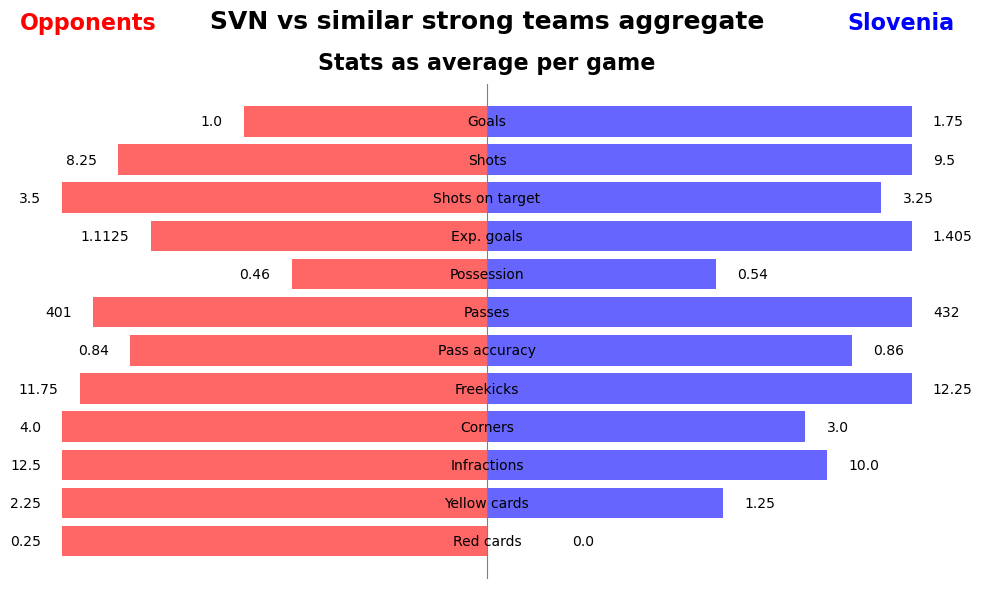

In [81]:
team_type_counts = df_events.groupby(['team.name', 'type.primary']).size().unstack(fill_value=0)
shots_team2 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team2)]
shots_team1 = df_events[(~df_events["shot.isGoal"].isnull()) & (df_events["team.name"] == team1)]
passes_completed = df_events[df_events["type.primary"] == "pass"].groupby(['team.name'])['pass.accurate'].sum()
possession = df_events.groupby("team.name")["possession.duration"].sum() / df_events["possession.duration"].sum()
num_matches = len(match_ids)

team2_data = {'Goals': 0 if shots_team2['shot.isGoal'].sum() == False else shots_team2['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team2.shape[0] / num_matches,
            'Shots on target':0 if shots_team2['shot.onTarget'].sum() == False else shots_team2['shot.onTarget'].sum( ) / num_matches,
            'Exp. goals': shots_team2['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team2]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team2, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team2] / team_type_counts.loc[team2, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team2, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team2, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team2, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team2) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

team1_data = {'Goals': shots_team1['shot.isGoal'].sum() / num_matches,
            'Shots': shots_team1.shape[0] / num_matches,
            'Shots on target': shots_team1['shot.onTarget'].sum() / num_matches,
            'Exp. goals': shots_team1['shot.xg'].sum().round(2) / num_matches,
            'Possession': (possession.loc[team1]).round(2), # in percent
            'Passes': int(team_type_counts.loc[team1, 'pass'] / num_matches),
            'Pass accuracy': (passes_completed.loc[team1] / team_type_counts.loc[team1, 'pass']).round(2),
            'Freekicks': team_type_counts.loc[team1, 'free_kick'] / num_matches,
            'Corners': team_type_counts.loc[team1, 'corner'] / num_matches,
            'Infractions': team_type_counts.loc[team1, 'infraction'] / num_matches,
            'Yellow cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.yellowCard"] == True)].shape[0] / num_matches,
            'Red cards': df_events[(df_events["team.name"] == team1) & (df_events["infraction.redCard"] == True)].shape[0] / num_matches,
            }

# if category % do not normalize
perc_categories = ['Possession', 'Pass accuracy']

# plot statistics
plot_stats_barchart(team1_data, team2_data, team1_name=team1, team2_name=team2, perc_categories=perc_categories, title=title, 
                    subtitle=subtitle, team1_color='blue', team2_color='red', saveplt=True, savepath=f'plots/2-statistics/key_statistics_SVN_vs_similar.png')
